## Risk Parity Investment Strategy
#### Goal is to make portfolio which consists of diverse asset classes
Use ETF data of representative asset classes  
Developed-Emerging Equity, Real Estate, Commmodity, Treasury, Corporate Bond, TIPS are included in universe  
Resuld is driven from 2010 to 2021 market data  

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

In [3]:
import quantstats

In [4]:
from scipy.optimize import minimize

In [5]:
print("current directory is : ", os.getcwd())
os.chdir('/mnt/e/workspace/project_quant/')
print("changed directory is : ", os.getcwd())

current directory is :  /mnt/e/workspace/project_quant/asset_allocation_rev
changed directory is :  /mnt/e/workspace/project_quant


In [6]:
from backtest.backtest_engine import BacktestEngine
from backtest.target_generator import TargetGenerator

In [7]:
from benchmark_strategy.equal_weight import EqualWeightGenerator
from benchmark_strategy._60_40_allocation import _60_40_allocation
from benchmark_strategy._50_50_allocation import _50_50_allocation

[__init__] is executed in 2.67 seconds
[__init__] is executed in 3.75 seconds
[__init__] is executed in 3.43 seconds


In [8]:
class RiskParity(TargetGenerator):
    def __init__(self, cache):
        super().__init__(cache)
    
    def compute_target(self, universe_list):
        """
        Inputs
            universe_list(list) : list of ETFs that weights should be computed
        Outputs
            target_weight(dict)
        """
        date = engine.date
        target_weight = {}
        target_weight =  self.compute_factor(date = date, tickers=universe_list)

        return target_weight
    
    def compute_factor(self, date, tickers):
        """
        to calculate r
        :param covariance_matrix: covariance matrix of assets in universe
        :return: [list] weight of risk parity investment strategy
        """
        date_12_month_lag = date - relativedelta(months=12)
        return_df = pd.DataFrame()
        for ticker in tickers:
            asset_series = self.cache['index'][ticker]['closeadj']
            asset_series.rename(ticker, inplace=True)
            return_df[ticker] = asset_series
        
        return_df = return_df.loc[date_12_month_lag : date]
        return_df =  return_df.pct_change().fillna(0)
        # return_df = return_df.fillna(1)
        # self.return_df_dd = return_df

        covariance_matrix = return_df.cov()
        target = {}        

        x0 = np.repeat(1/covariance_matrix.shape[1], covariance_matrix.shape[1])
        constraints = ({'type': 'eq', 'fun': self.SumConstraint},
                    {'type': 'ineq', 'fun': self.LongOnly})
        options = {'ftol': 1e-20, 'maxiter': 2000}

        result = minimize(fun = self.RiskParityObjective,
                        args = (covariance_matrix),
                        x0 = x0,
                        method = 'SLSQP',
                        constraints = constraints,
                        options = options)

        target = {}
        for i in range(len(custom_universe)):
            target[custom_universe[i]] = result.x[i]

        return target


    def RiskParityObjective(self, x, covariance_matrix) :
        # x means weight of portfolio
        variance = (x.T) @ (covariance_matrix) @ (x)
        sigma = np.sqrt(variance)
        mrc = 1/sigma * (covariance_matrix @ x)
        risk_contribution = x * mrc
        a = np.reshape(risk_contribution.to_numpy(), (len(risk_contribution), 1))

        # set marginal risk level of asset classes equal
        risk_diffs = a - a.T
        # np.ravel: convert n-dim to 1-dim
        sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
        return (sum_risk_diffs_squared)

    # constraint 1 : sum of weight should be less than equal to 1
    def SumConstraint(self, weight):
        return (weight.sum()-1.0)

    # constraint 2 : long only portfolio should be consists of postive weight vectors
    def LongOnly(self, weight):
        return(weight)
    
    # calculate risk contribution
    def RiskContribution(weight, covariance_matrix) :
        """
        to check whether given portfolio is equally distributed
        :param weight: asset allocation weight of portfolio
        :param covariance_matrix:
        :return: risk contribution of each asset
        """
        weight = np.array(weight)
        variance = np.dot(np.dot(weight.T, covariance_matrix) ,weight)
        sigma = np.sqrt(variance)
        mrc = 1/sigma * np.dot(covariance_matrix, weight)

        risk_contribution = weight * mrc
        risk_contribution = risk_contribution / risk_contribution.sum()
        return risk_contribution

In [ ]:
custom_universe = [
    'SPY', # SPDR S&P 500 ETF Trust
    'EFA', # iShares MSCI EAFE ETF
    'EEM', # iShares MSCI Emerging Markets ETF
    'TLT', # iShares 20+ Year Treasury Bond ETF
    'IEF', # iShares 7-10 Year Treasury Bond ETF
    'SHY', # iShares 1-3 Year Treasury Bond ETF
    'LQD', # iShares iBoxx Investment Grade Corporate Bond ETF
    'TIP', # iShares TIPS Bond ETF
    'VNQ', # Vanguard Real Estate Index Fund
    'GLD'  # SPDR Gold Shares
    ]


In [9]:
engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
rp = RiskParity(engine.cache)
engine.run_backtest(target_generator=rp, sdate='2010-01-01', edate='2022-06-15', transaction_cost=0.001)
my_strategy = engine.asset_df.sum(axis=1)

[__init__] is executed in 7.69 seconds
Backtest period: 2010-01-04 00:00:00 -- 2022-06-15 00:00:00
=== date:2022-06-15 00:00:00 / total_asset:2.807 / time elapsed:97.2 ===
[run_backtest] is executed in 97.87 seconds


In [10]:
bm_engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
equal = EqualWeightGenerator(bm_engine.cache)
bm_engine.run_backtest(target_generator=equal, sdate='2010-01-01', edate='2022-06-15', transaction_cost=0.001)
bm_strategy = bm_engine.asset_df.sum(axis=1)

[__init__] is executed in 13.14 seconds
Backtest period: 2010-01-04 00:00:00 -- 2022-06-15 00:00:00
=== date:2022-06-15 00:00:00 / total_asset:1.894 / time elapsed:4.4 ===
[run_backtest] is executed in 4.51 seconds


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2010-01-04  2010-01-04
End Period                 2022-06-15  2022-06-15
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          180.99%     89.56%
CAGR﹪                     8.65%       5.27%

Sharpe                     0.71        0.72
Smart Sharpe               0.68        0.7
Sortino                    0.98        0.99
Smart Sortino              0.95        0.96
Sortino/√2                 0.69        0.7
Smart Sortino/√2           0.67        0.68
Omega                      1.14        1.14

Max Drawdown               -24.75%     -16.2%
Longest DD Days            446         415
Volatility (ann.)          12.96%      7.54%
R^2                        0.75        0.75
Calmar                     0.35        0.33
Skew                       -0.68       -0.87
Kurtosis                   10.91       10.88

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-24,2020-03-23,2020-11-10,260,-24.747167,-23.520701
2,2022-01-03,2022-06-14,2022-06-15,163,-19.257835,-17.827382
3,2013-05-22,2013-08-19,2014-06-02,376,-14.163799,-13.222100
4,2011-07-25,2011-10-03,2012-01-20,179,-13.730722,-12.163374
5,2015-01-28,2015-09-04,2016-04-18,446,-11.789943,-11.414978


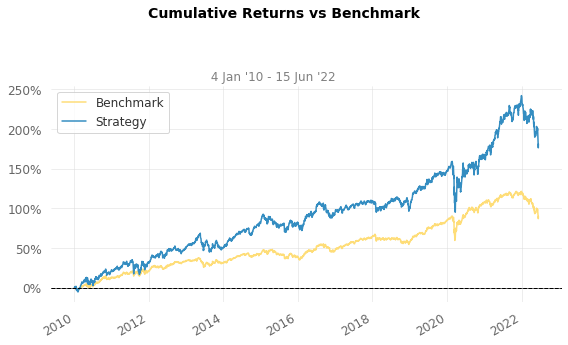

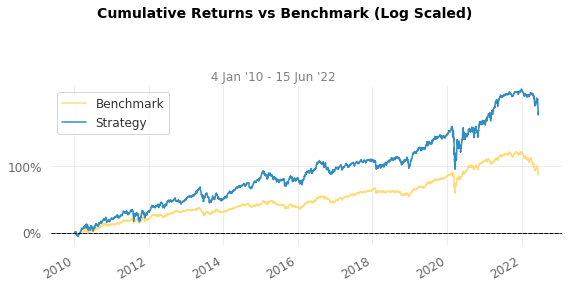

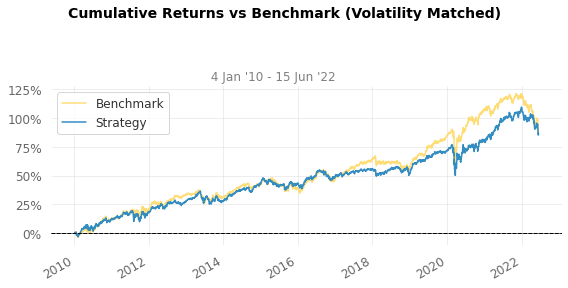

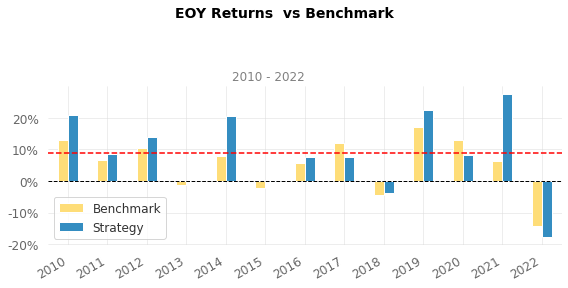

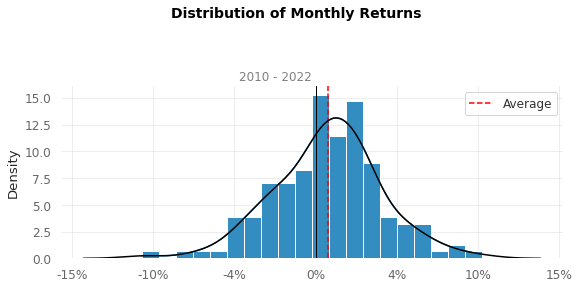

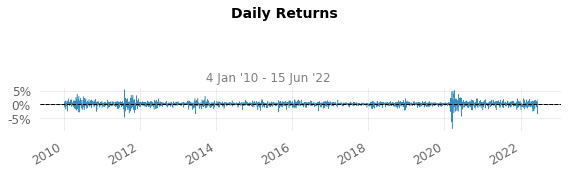

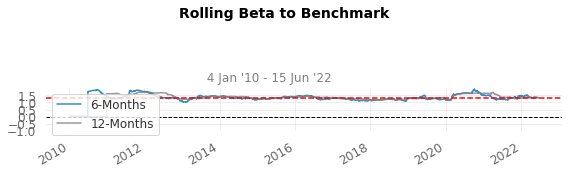

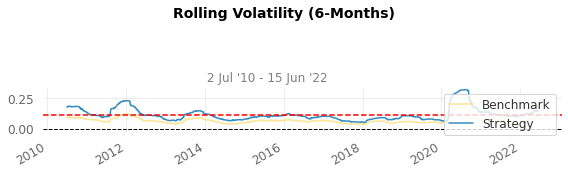

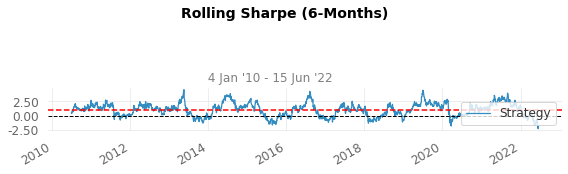

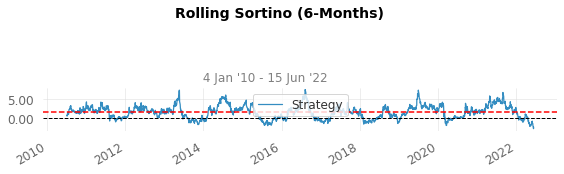

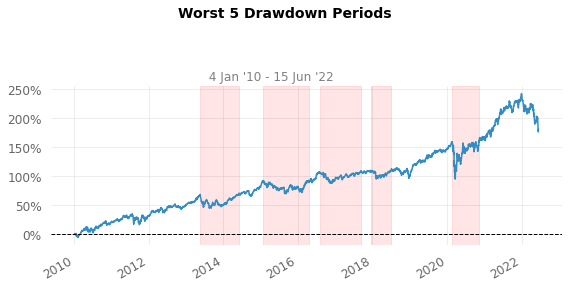

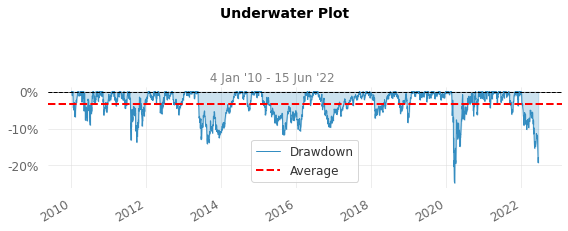

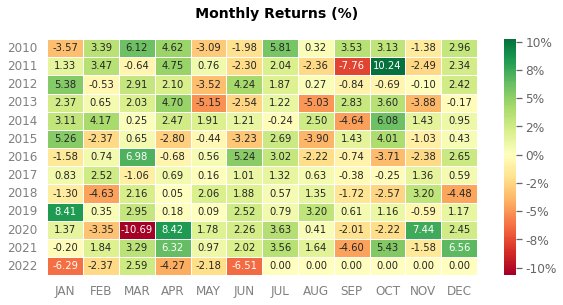

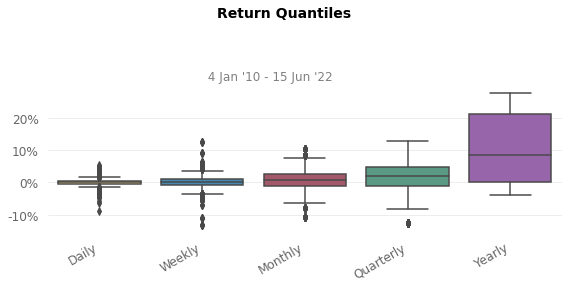

In [18]:
quantstats.reports.full(returns=my_strategy, benchmark=bm_strategy)